In [1]:
from moves import *
from itertools import product
from typing import Callable
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def get_loc(location, action, move_dic):
    try:
        return move_dic[tuple([int(location), int(action)])]
    except KeyError:
        return location


def get_reward(player, location, action):
    if player == 1 and location == 7 and action == 3:
        return 100
    if player == 0 and location == 11 and action ==3:
        return 100
    return 1

In [5]:
# Find the best policy given a set of values
def get_path(best_actions, loc_fn, move_dic, p1, p2, t1, t2, gamma):
    s = (p1, p2)
    i = 0
    reward1 = []
    reward2 = []
    while s[0] not in t1 and s[1] not in  t2:
        a1, a2 = best_actions[s]
        r1 = get_reward(0, p1, a1)
        r2 = get_reward(1, p2, a2)
        p1n = loc_fn(p1, a1, move_dic)
        p2n = loc_fn(p2, a2, move_dic)
        sn = (p1n, p2n)
        # print(f'I started at {s}, took action {a1, a2} and moved to {sn} ')
        s = sn
        p1 = p1n
        p2 = p2n
        reward1.append(r1*gamma**i)
        reward2.append(r2*gamma**i)
        i += 1
    return s, i, reward1, reward2

In [6]:
# Perform value iteration on the myopic rewards
def reward_nash(us):
    return np.sum(np.log(us))

def reward_util(us):
    return np.sum(us)

def reward_egal(us):
    return min(us)

def reward_eite(us):
    return max(us)

def value_iteration(num_states: int, num_actions: int, loc_fn: Callable,
                    get_reward: Callable, move_dic: dict, t1: list, t2: list, gamma: float, swf: Callable):
    # Set some paramaters and initial values
    gamma = gamma
    u1 = 1
    u2 = 1
    values = {(i, j): 0 for i in range(num_states) for j in range(num_states)}
    best_actions = {(i, j): None for i in range(num_states) for j in range(num_states)}
    converged = False

    while not converged:
        # Convergence is defined for when the max shift in our state value is less than 1e-4
        converged = True
        for s in values:
            best_value = -np.inf
            best_move = None
            p1 = s[0]
            p2 = s[1]
            for i, move in enumerate(product(list(range(num_actions)), list(range(num_actions)))):
                # Iterate through all moves and find the best one
                a1 = move[0]
                a2 = move[1]
                p1n = loc_fn(p1, a1, move_dic)
                p2n = loc_fn(p2, a2, move_dic)
                r1 = get_reward(0, p1, a1)
                r2 = get_reward(1, p2, a2)
                if p1n == p2n or (p1n == p2 and p2n == p1):
                    r1 = 1
                    r2 = 1
                    p1n = p1
                    p2n = p2
                # Plot global welfare (cumulative discounted utility functions) v(state) = sum(r_t*gamma^t
                u1n = u1 + gamma*r1
                u2n = u2 + gamma*r2
                # Wasn't sure whether to use augmented or normal MDP here. If normal MDP is used, we have to give non-zero reward
                # reward = np.sum(np.log([u1n, u2n])) - np.sum(np.log([u1, u2]))
                # u1 = 1 + 1*gamma + 1*gamma^2 + 1*gamma^3 + 100*gamma^4
                # u1, u2, welfare
                reward = swf([r1, r2])
                value = reward + gamma*values[(p1n, p2n)]
                if p1 in t1 or p2 in t2:
                    # Terminal states have value 0 by definition
                    value = 0
                if value > best_value:
                    best_value = value
                    best_move = move
            if abs(best_value - values[s]) > 1e-4:
                converged = False
            values[s] = best_value
            best_actions[s] = best_move
    return values, best_actions

In [7]:
# Only one of two stratgeies can ever be optimal, either run to the end or wait and go to he end together (1 and 2, respectively)
opt = 0
actuals_nash = []
bests_nash = []

swf = reward_nash
for g in range(98):
    g = (g + 1)/100

    strat_2_value = [g**(k) for k in range(6)]
    strat_2_value.append(100*g**6)
    strat_2_value = sum(strat_2_value)
    strat_2 = swf([strat_2_value, strat_2_value])

    values, best_actions = value_iteration(14, 4, get_loc, get_reward, moves1, t1=[3], t2=[1], gamma=g, swf=swf)
    terminal, num_steps, r1, r2 = get_path(best_actions, get_loc, moves1, 7, 11, [3], [1], g)
    actual1 = sum(r1)
    actual2 = sum(r2)
    actual = swf([actual1, actual2])
    strategy = 1
    if terminal == (3, 1):
        strategy = 2
    # Since we know only one of two can be best, we can just say the globally optimal will be the max of those.global
    # The actual path will either follow strat_1 or strat 2, so this will set global best to strat_1 if it did better
    best = max(actual, strat_2)
    actuals_nash.append(actual)
    bests_nash.append(best)

    print(f'I am running strategy {strategy} for {g} with value {values[(7, 11)]}, {actual - best}')

I am running strategy 1 for 0.01 with value 4.6051701859880923e-08, 0.0
I am running strategy 1 for 0.02 with value 7.368272297580948e-07, 0.0
I am running strategy 1 for 0.03 with value 3.7301878506503532e-06, 0.0
I am running strategy 1 for 0.04 with value 1.1789235676129516e-05, 0.0
I am running strategy 1 for 0.05 with value 2.878231366242558e-05, 0.0
I am running strategy 1 for 0.06 with value 5.968300561040565e-05, 0.0
I am running strategy 1 for 0.07 with value 0.00011057013616557413, 0.0
I am running strategy 1 for 0.08 with value 0.00018862777081807226, 0.0
I am running strategy 1 for 0.09 with value 0.00030214521590267863, 0.0
I am running strategy 1 for 0.1 with value 0.00046051701859880926, 0.0
I am running strategy 1 for 0.11 with value 0.0006742429669305165, 0.0
I am running strategy 1 for 0.12 with value 0.0009549280897664904, 0.0
I am running strategy 1 for 0.13 with value 0.0013152826568200594, 0.0
I am running strategy 1 for 0.14 with value 0.001769122178649186, 0.0
I

I am running strategy 1 for 0.01 with value 1.010102, 0.0
I am running strategy 1 for 0.02 with value 1.020424, 0.0
I am running strategy 1 for 0.03 with value 1.031008, 0.0
I am running strategy 1 for 0.04 with value 1.04192, 0.0
I am running strategy 1 for 0.05 with value 1.05325, 0.0
I am running strategy 1 for 0.06 with value 1.065112, 0.0
I am running strategy 1 for 0.07 with value 1.077644, 0.0
I am running strategy 1 for 0.08 with value 1.091008, 0.0
I am running strategy 1 for 0.09 with value 1.10539, 0.0
I am running strategy 1 for 0.1 with value 1.121, 0.0
I am running strategy 1 for 0.11 with value 1.138072, 0.0
I am running strategy 1 for 0.12 with value 1.156864, 0.0
I am running strategy 1 for 0.13 with value 1.177658, 0.0
I am running strategy 1 for 0.14 with value 1.20076, 0.0
I am running strategy 1 for 0.15 with value 1.2265, 0.0
I am running strategy 1 for 0.16 with value 1.255232, 0.0
I am running strategy 1 for 0.17 with value 1.287334, 0.0
I am running strategy 1 

C:\Users\Chris\AppData\Local\Temp\ipykernel_1212\2350679500.py:41: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


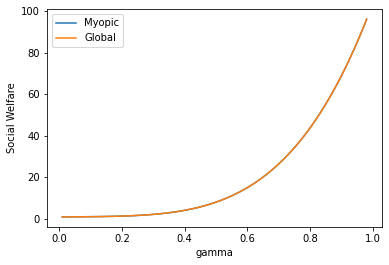

In [8]:
opt = 0
actuals_elite = []
bests_elite = []

swf = reward_eite
for g in range(98):
    g = (g + 1)/100
    strat_2_value = [g**(k) for k in range(6)]
    strat_2_value.append(100*g**6)
    strat_2_value = sum(strat_2_value)
    strat_2 = swf([strat_2_value, strat_2_value])

    values, best_actions = value_iteration(14, 4, get_loc, get_reward, moves1, t1=[3], t2=[1], gamma=g, swf=swf)
    terminal, num_steps, r1, r2 = get_path(best_actions, get_loc, moves1, 7, 11, [3], [1], g)
    actual1 = sum(r1)
    actual2 = sum(r2)
    actual = swf([actual1, actual2])
    strategy = 1
    if terminal == (3, 1):
        strategy = 2

    best = max(actual, strat_2)
    actuals_elite.append(actual)
    bests_elite.append(best)

    print(f'I am running strategy {strategy} for {g} with value {values[(7, 11)]}, {actual - best}')


# fig = plt.figure()
# x = np.arange(.01, .99, .01)
# ax = fig.add_subplot()
# ax.plot(x, actuals_elite, label='Myopic')
# ax.plot(x, bests_elite, label='Global')
# x_ticks = [(a + 1)/100 for a in range(99)]
# x = range(99)
# plt.xlabel('gamma')
# plt.ylabel('Social Welfare')
# # [l.set_visible(False) for (i,l) in enumerate(plt.xaxis.get_ticklabels()) if i % 10 != 0]
#
# plt.legend()
# fig.show()

I am running strategy 2 for 0.01 with value 1.0101010101010102, -9.89799353590115e-11
I am running strategy 2 for 0.02 with value 1.0204081696, 0.0
I am running strategy 2 for 0.03 with value 1.0309279072, 0.0
I am running strategy 2 for 0.04 with value 1.041667072, 0.0
I am running strategy 2 for 0.05 with value 1.052633125, 0.0
I am running strategy 2 for 0.06 with value 1.0638344032, 0.0
I am running strategy 2 for 0.07 with value 1.0752804556, 0.0
I am running strategy 2 for 0.08 with value 1.0869824512, 0.0
I am running strategy 2 for 0.09 with value 1.098953659, 0.0
I am running strategy 2 for 0.1 with value 1.11121, 0.0
I am running strategy 2 for 0.11 with value 1.1237706712, 0.0
I am running strategy 2 for 0.12 with value 1.1366588416, 0.0
I am running strategy 2 for 0.13 with value 1.1499024202, 0.0
I am running strategy 2 for 0.14 with value 1.163534896, 0.0
I am running strategy 2 for 0.15 with value 1.17759625, 0.0
I am running strategy 2 for 0.16 with value 1.1921339392, 

C:\Users\Chris\AppData\Local\Temp\ipykernel_1212\1602950446.py:42: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


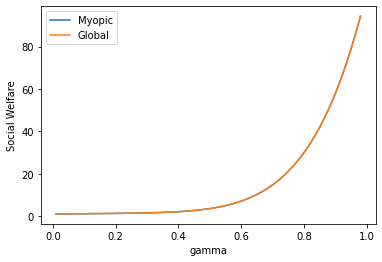

In [9]:
opt = 0
actuals_egal = []
bests_egal = []

swf = reward_egal
for g in range(98):
    g = (g + 1)/100
    strat_2_value = [g**(k) for k in range(6)]
    strat_2_value.append(100*g**6)
    strat_2_value = sum(strat_2_value)
    strat_2 = swf([strat_2_value, strat_2_value])

    values, best_actions = value_iteration(14, 4, get_loc, get_reward, moves1, t1=[3], t2=[1], gamma=g, swf=swf)
    terminal, num_steps, r1, r2 = get_path(best_actions, get_loc, moves1, 7, 11, [3], [1], g)
    actual1 = sum(r1)
    actual2 = sum(r2)
    actual = swf([actual1, actual2])
    strategy = 1
    if terminal == (3, 1):
        strategy = 2

    best = max(actual, strat_2)
    actuals_egal.append(actual)
    bests_egal.append(best)

    print(f'I am running strategy {strategy} for {g} with value {values[(7, 11)]}, {actual - best}')


fig = plt.figure()
x = np.arange(.01, .99, .01)
ax = fig.add_subplot()
ax.plot(x, actuals_egal, label='Myopic')
ax.plot(x, bests_egal, label='Global')
x_ticks = [(a + 1)/100 for a in range(99)]
x = range(99)
plt.xlabel('gamma')
plt.ylabel('Social Welfare')
# ax.set_xticks(np.arange(0, 100, 5))
# [l.set_visible(False) for (i,l) in enumerate(plt.xaxis.get_ticklabels()) if i % 10 != 0]

plt.legend()
fig.show()

I am running strategy 1 for 0.01 with value 2.02020301, 0.0
I am running strategy 1 for 0.02 with value 2.04083216, 0.0
I am running strategy 1 for 0.03 with value 2.06193581, 0.0
I am running strategy 1 for 0.04 with value 2.08358656, 0.0
I am running strategy 1 for 0.05 with value 2.10588125, 0.0
I am running strategy 1 for 0.06 with value 2.12894096, 0.0
I am running strategy 1 for 0.07 with value 2.15291101, 0.0
I am running strategy 1 for 0.08 with value 2.17796096, 0.0
I am running strategy 1 for 0.09 with value 2.20428461, 0.0
I am running strategy 1 for 0.1 with value 2.2321, 0.0
I am running strategy 1 for 0.11 with value 2.26164941, 0.0
I am running strategy 1 for 0.12 with value 2.29319936, 0.0
I am running strategy 1 for 0.13 with value 2.32704061, 0.0
I am running strategy 1 for 0.14 with value 2.36348816, 0.0
I am running strategy 1 for 0.15 with value 2.40288125, 0.0
I am running strategy 1 for 0.16 with value 2.44558336, 0.0
I am running strategy 1 for 0.17 with value 2

C:\Users\Chris\AppData\Local\Temp\ipykernel_1212\3840075275.py:41: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


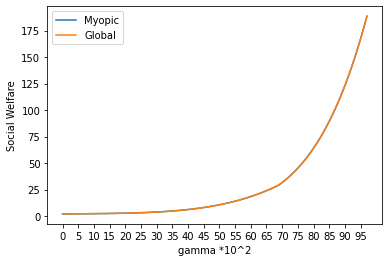

In [10]:
opt = 0
actuals_util = []
bests_util = []

swf = reward_util
for g in range(98):
    g = (g + 1)/100
    best_value = [g**(k) for k in range(6)]
    best_value.append(100*g**6)
    best_value = sum(best_value)
    best = swf([best_value, best_value])

    values, best_actions = value_iteration(14, 4, get_loc, get_reward, moves1, t1=[3], t2=[1], gamma=g, swf=swf)
    terminal, num_steps, r1, r2 = get_path(best_actions, get_loc, moves1, 7, 11, [3], [1], g)
    actual1 = sum(r1)
    actual2 = sum(r2)
    actual = swf([actual1, actual2])
    strategy = 1
    if terminal == (3, 1):
        strategy = 2

    best = max(actual, best)
    actuals_util.append(actual)
    bests_util.append(best)

    print(f'I am running strategy {strategy} for {g} with value {values[(7, 11)]}, {actual - best}')


fig = plt.figure()
ax = fig.add_subplot()
ax.plot(actuals_util, label='Myopic')
ax.plot(bests_util, label='Global')
x_ticks = [(a + 1)/100 for a in range(99)]
x = range(99)
plt.xlabel('gamma *10^2')
plt.ylabel('Social Welfare')
ax.set_xticks(np.arange(0, 100, 5))
# [l.set_visible(False) for (i,l) in enumerate(plt.xaxis.get_ticklabels()) if i % 10 != 0]

plt.legend()
fig.show()

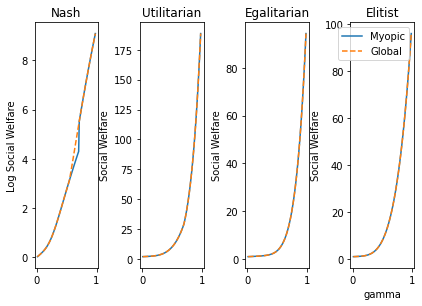

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FormatStrFormatter

fig,axs = plt.subplots(1, 4)
ax1 = axs[0]
ax2 = axs[1]
ax3 = axs[2]
ax4 = axs[3]
fig.tight_layout(h_pad=2)

x = np.arange(.01, .99, .01)
#ax1 = fig.add_subplot()
ax1.plot(x, actuals_nash, label='Myopic')
ax1.plot(x, bests_nash, '--', label='Global')
ax1.set_title('Nash')
# ax1.set_xlabel('gamma')
ax1.set_ylabel('Log Social Welfare')
# ax1.legend()


ax2.plot(x, actuals_util, label='Myopic')
ax2.plot(x, bests_util, '--', label='Global')
ax2.set_title('Utilitarian')
# ax2.set_xlabel('gamma')
ax2.set_ylabel('Social Welfare')
# ax2.legend()

ax3.plot(x, actuals_egal, label='Myopic')
ax3.plot(x, bests_egal, '--', label='Global')
ax3.set_title('Egalitarian')
# ax3.set_xlabel('gamma')
ax3.set_ylabel('Social Welfare')
# ax3.legend()

ax4.plot(x, actuals_elite, label='Myopic')
ax4.plot(x, bests_elite, '--', label='Global')
ax4.set_title('Elitist')
ax4.set_xlabel('gamma')
ax4.set_ylabel('Social Welfare')
ax4.legend()

ax4.get_shared_x_axes().join(ax1, ax2, ax3, ax4)

# ax.set_xticks(np.arange(0, 100, 5))
# [l.set_visible(False) for (i,l) in enumerate(plt.xaxis.get_ticklabels()) if i % 10 != 0]